![banner](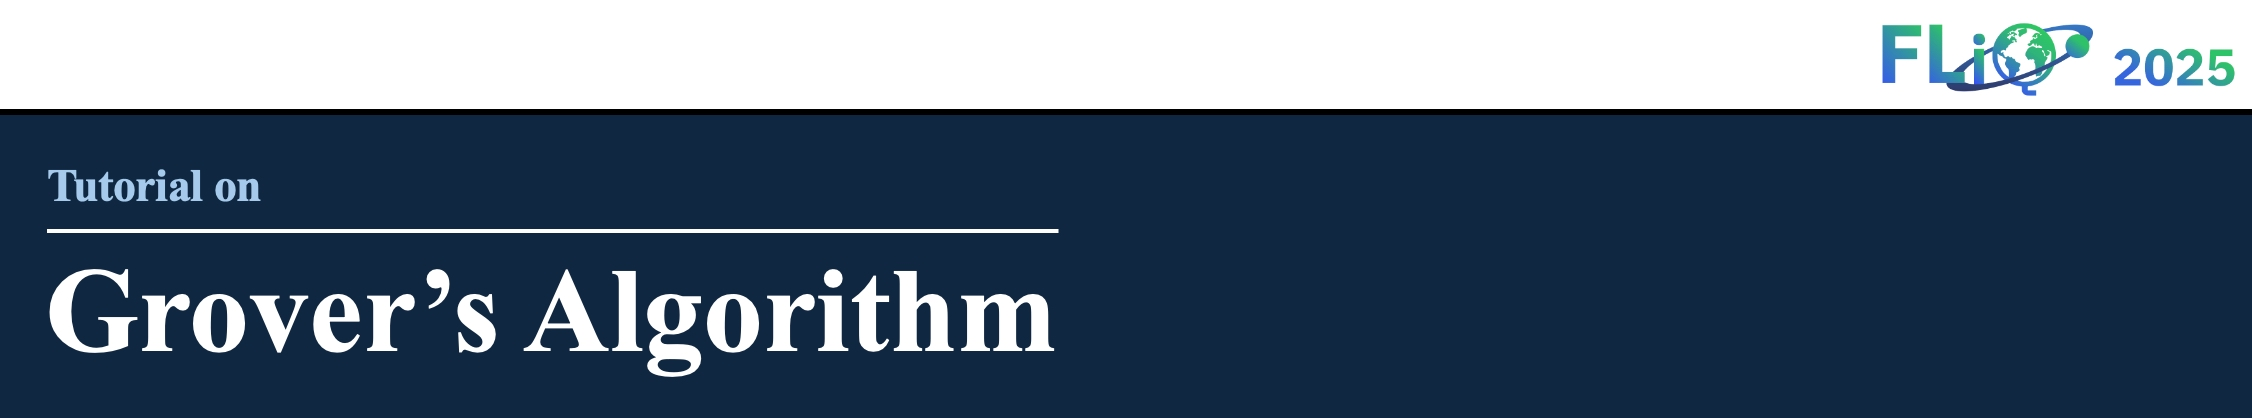
)

Written by Felix Arkle and Sebastian Gotto

## Notebook Setup Requirements

In [45]:
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display
from numpy import pi

## Learning Goals

1. **Define** the search problem in terms of an oracle function
2. **Outline** the key ingredients of Grover’s algorithm
3. **Describe** each step of the algorithm
4. **Show how** many iterations are needed for high success probability

## Concepts that are handy
- Basic Python
- Basic linear algebra (vectors and matrices)
- Binary numbers and logic
- Might be nice to have been introduced to Quantum gates but not essential!

## Contents Table
1. Introduction to Grover's Algorithm
2. Hadamard Gates and Superposition
3. Oracle Design and Phase Flips
4. Diffusion Operator and Amplification
5. Full Circuit Construction
6. Testing
7. Run on Real Hardware

## **Introduction**: What is Grover's Algorithm?

Grover's algorithm is a quantum algorithm, proposed by Lov Grover in 1996, that allows us to search for an item in an unstructured database much faster than any classical algorithm. In this notebook, we'll build up the concepts step-by-step, culminating in a basic working Grover circuit you can run on a simulator and real IBM hardware. But first let's define some useful notation to help understand Grover's Algorithm which you can refer back to throughout the tutorial.

**How to use this tutorial:** Work through at your own pace, try every exercise and thought experiment, explore and have fun!

<div style="
  background-color: rgba(255, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid #ffd700;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Definition 1: Big O Notation (Informal)</b> <br>

---
Big O notation describes how the running time of an algorithm grows as the input size $n$ increases. If an algorithm does at most a $g(n)$ steps for large $n$, we say its time is $O\bigl(g(n)\bigr)$. For example:

- **Linear time** $O(n)$: If $n$ goes up by a factor of ten, the runtime also goes up by a factor of ten.
- **Quadratic time** $O(n^2)$: If $n$ goes up by a factor of ten, the runtime goes up by a factor of one hundred.
- **Square root time** $O(\sqrt{n})$: If $n$ goes up by a factor of one hundred, the runtime only goes up by a factor of ten.

</div>
 <br><br>
<div style="
  background-color: rgba(255, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid #ffd700;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Definition 2: Ket Notation</b> <br>

---
In quantum mechanics, we write the state of a system as a *ket*, for example $∣\psi⟩$. Think of it like a name for a list of numbers that describe the system:

- For a single bit in the “0” state we write $\ket{0}$, which you can imagine as the list $(1,0)$.
- For the “1” state we write $\ket{1}$, which is the list $(0,1)$.

A qubit can be in a mix of both (superposition), like
$$
∣ψ⟩=α∣0⟩+β∣1⟩,
$$

where $\alpha$ and $\beta$ are numbers that tell us how likely we are to see $0$ or $1$ when we measure.

More generally, for $n$ quibits you need $2^n$ numbers to describe the state. This means the size of the list (and the amount of information) doubles for each extra quibit.

</div>
 <br><br>
<div style="
  background-color: rgba(255, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid #ffd700;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Definition 3: Oracle</b> <br>


---

An 0racle Operator $O_f$ is a controlled phase flip that multiplies the amplitude of the marked state by -1:
$$
O_f∣x⟩=(−1)^{f(x)}∣x⟩
$$


</div>


So what is Grover's algorithm attempting to solve?


### The Problem: 

Lets say you have $ N $ items (e.g $00$, $01$, $10$, $11$). One of them is the correct answer. For a classical computer you need to check each one individually - one at a time.

On average, a classical search finds the answer in about $ \frac{N}{2} $ guesses

Quantum Advantage: What make's Grover's algorithm more powerful is that fact that it can find the answer in about $ \sqrt{N} $ steps. This is utilising quantum phenomina, parallelism and interference.

So: 
- For 4 items: Classical would on average take 2 steps ->
Quantum would take however 1 step on average. 

- For 1000000 items
Classical would take 500,000 ->
Quantum would take 1,000

<div style="
  background-color: rgba(38, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(37, 208, 117);
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Analogy 1: Grover’s Algorithm as a Magical Quantum Dice Trick - Solving a Hidden Puzzle</b> <br>

---

**Step 1:** The Problem - Find the Magic Number

- You’re faced with a puzzle: there's a correct answer hidden among multiple options - we call it the solution state or “magic number.”

- Imagine someone has picked a secret number between 1 and 4 and locked it in a box. Your goal is to find it - but you're not allowed to just ask for the answer. You have to search for it, without knowing what you're looking for.

- In the quantum world, you represent the search space using qubits. For 2 qubits, you have 4 possible states:

$$
\text{∣00⟩,∣01⟩,∣10⟩,∣11⟩}
$$
**Step 2:** A Fair 4-Sided Die (Uniform Superposition)

- Imagine a 4-sided die where each face is labeled 00, 01, 10, and 11. Normally, when you roll the die, each face has a 25% chance of showing up.

- In quantum computing, applying Hadamard gates puts the qubits into a state where all outcomes exist simultaneously - a superposition.

- You haven’t rolled the die yet. It's like the die is floating in the air, with all sides present at once.

**Step 3:** The Invisible Sticky Side (Oracle)

- Now, someone secretly applies invisible glue to one side of the die - say |11⟩ - but you don’t know which one.

- That’s the oracle. It marks the correct answer by flipping its quantum phase, not something visible to you.

- So now:
$$
∣𝜓⟩=(∣00⟩+∣01⟩+∣10⟩−∣11⟩)
$$

- But you still can’t tell what the correct answer is. Nothing "looks" different yet. You still don’t know which face is sticky.

**Step 4:** Weighted Paint (Diffusion Operator)

- Next, we apply a magic paint to the entire die. This paint somehow senses the invisible glue and makes that side heavier - so when you roll the die, it’s more likely to land face-up.

- This is the diffusion operator, which amplifies the marked state by increasing its amplitude.

- Now one side of the die is quantum-weighted. But again, you still don’t know which one until you roll it.

**Step 5:** The Roll (Measurement)

- Now, you roll the die.

- This is quantum measurement: all possibilities collapse and you get one single outcome, ideally the sticky, weighted face that we amplified earlier.

- So only when you measure do you learn what the answer is.

**Summary:**

<div align="center">

<table>
  <thead>
    <tr>
      <th>Quantum Concept</th>
      <th>Dice Analogy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Superposition</td>
      <td>All faces of the die active at once</td>
    </tr>
    <tr>
      <td>Oracle (phase flip)</td>
      <td>Invisible glue on the correct face</td>
    </tr>
    <tr>
      <td>Diffusion (amplification)</td>
      <td>Weighted paint makes that face more likely</td>
    </tr>
    <tr>
      <td>Measurement</td>
      <td>Rolling the die and revealing the answer</td>
    </tr>
    <tr>
      <td>Hidden target</td>
      <td>You never know which face was marked until roll</td>
    </tr>
  </tbody>
</table>

</div>

**Key Concept**:

Even though you've prepared the system perfectly, with the oracle and diffusion, you only know the answer when you roll the die (measure the qubits). Until then, all outcomes are still entangled in quantum possibility.

Grover’s algorithm is not just a party trick, it’s a way to solve search problems faster than any classical method. You:
- Search without knowing the answer
- Tag the answer with a phase flip
- Amplify the signal through interference
- Measure to collapse and retrieve the solution

All of this takes fewer steps than a classical computer would ever need.

</div>

***Takeaway:***

*- Classical search is linear in the number of items*

*- It becomes slow and inefficient as the number of possibilities grows*

*- This is where Grover's quadratic speedup utilises weird quantum properties and becomes significantly faster and exciting!*

----

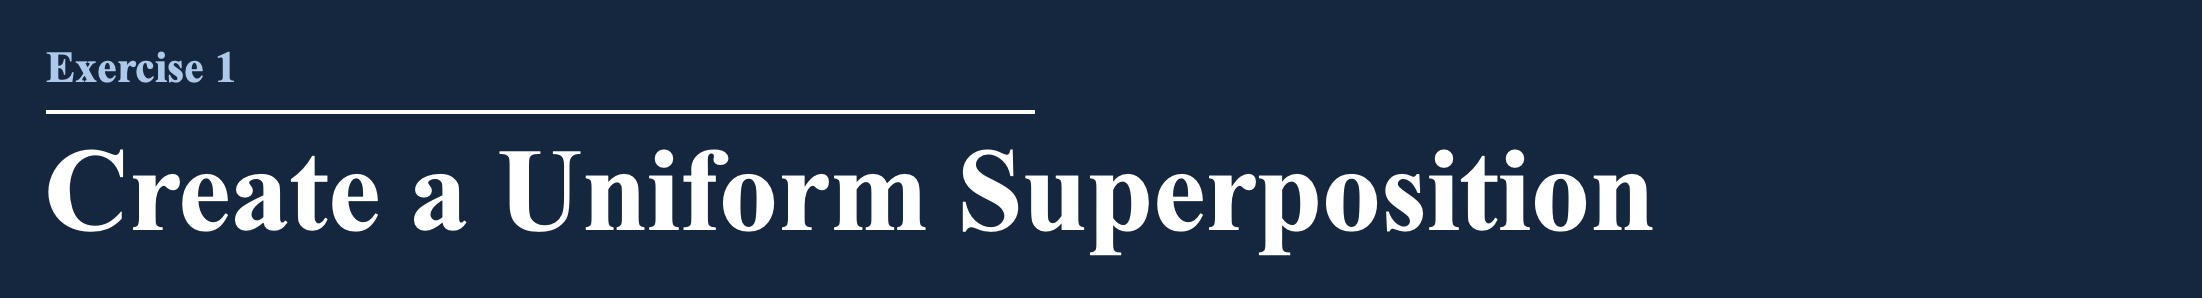

<div style="
  background-color: rgba(0, 170, 255, 0.1); 
  padding: 10px; 
  border-left: 3px solid #00aaff;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Task 1:</b> <br>

---

Create a quantum state where every possible 2-qubit combination has equal probability, this is the foundation of Grover's ability to search “everywhere at once.”

You’ll use Hadamard gates to place the qubits into superposition and then visualise the result.


</div>

**Theory:**

Before we can begin searching, we need to prepare the quantum system. In Grover’s algorithm, that means creating a state where all possible answers are equally likely. This is called a uniform superposition.

In classical computing, if you want to find an item in a list of 4, you would check each item one by one. In quantum computing, we take a different approach: we prepare all options simultaneously, then use interference to amplify the correct one and suppress the others. But for this to work, we need to start in a state where each answer has the same probability.

We achieve this by applying a Hadamard gate to each qubit. 

<div style="
  background-color: rgba(255, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid #ffd700;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Definition 4: The Hadamard gate</b> <br>

---

The Hadamard gate transforms a single qubit from the base state $\ket{0}$ into an equal mixture of  $\ket{0}$ and  $\ket{1}$ 

$$ H = \frac{1}{\sqrt{2}} \begin{bmatrix}1 & 1\\ 1 & -1\end{bmatrix} $$

Try applying a Hadamard gate yourself on a  $\ket{0}$ state, $ \begin{bmatrix}1\\ 0\end{bmatrix} $, what happens?


<details>
<summary> Answer </summary>

The Hadamard gate transforms a single qubit from the base state $\ket{0}$ into an equal mixture of $\ket{0}$ and $\ket{1}$

$$
H\ket{0}  \frac{1}{\sqrt{2}} \begin{bmatrix}1 & 1\\ 1 & -1\end{bmatrix} \begin{bmatrix}1\\ 0\end{bmatrix} =\frac{1}{\sqrt{2}} (∣0⟩+∣1⟩) $$

</details>


</div>

If we apply this to two qubits, we get:

$$ H ^{\otimes 2} \ket{00} = \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \times \frac{1}{\sqrt{2}} (\ket{0} + \ket{1})$$
$$ = \frac{1}{2} (\ket{00} + \ket{01} + \ket{10} + \ket{11})$$ 

This creates a state where all four outcomes have equal amplitude, $0.5^2 = 0.25 = 25 \%$, and thus equal probability when measured - exactly what we need for Grover's algorithm to work correctly.

Think of it like preparing a fair 4-sided die: The Hadamard gates are shaping the die so it's perfectly fair before we start the search.

**Exercise 1:**

Fix the equal_state() function to instead apply a Hadamard gate to all qubits, first run as is and observe the output, how can we use a for loop to apply a Hadamard gate to all qubits?

In [23]:
# =================================== #
# === Run this code as is first ===== #
# =================================== #

n_qubits = 2

def equal_state(n_qubits):
    """
    Create a new circuit and apply Hadamard gates to all qubits in the circuit.
    """

    # Create a quantum circuit with n_qubits qubits and n_qubit classical bits
    qc = QuantumCircuit(n_qubits, n_qubits)

    # ============================================================= #
    # TODO - FIX the circuit to create an equal superposition state
    # Use a for loop to apply Hadamard gates to all qubits

    qc.h(0)

    # ============================================================= #

    # Return the quantum circuit
    return qc

# Create fresh circuit with 2 qubits
qc = equal_state(n_qubits)

# Add measurement
qc.measure(range(n_qubits), range(n_qubits))

# Simulate the circuit using the QASM simulator
backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024) # Run the job and get the result
result = job.result()
counts = result.get_counts() # Get the measurement counts

*Run the report code below to get a visual of the quantum state, a histogram plot of your results and the quantum circuit you're made!*

In [24]:
# ====== View the state of the qubit  ====== #
qc.remove_final_measurements(inplace=True)
state = Statevector.from_instruction(qc)
display(state.draw('latex'))

In [25]:
# ====== Custom Report Layout - Do not edit  ====== #

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Histogram (left, spans both rows)
ax_hist = fig.add_subplot(gs[:, 0])
plot_histogram(counts, ax=ax_hist)
ax_hist.set_title("Measurement Histogram")

# Draw Circuit (top-right)
ax_circ = fig.add_subplot(gs[0, 1])
qc_with_meas = qc.copy()
qc_with_meas.measure_all()
qc_with_meas.draw(output='mpl', ax=ax_circ)
ax_circ.set_title("Quantum Circuit")

plt.tight_layout()
plt.show()

# ====== Custom Report Layout - Do not edit  ====== #

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

<details>
<summary> Solution - Try to google and play around before peeking at the solution</summary>

``` 
for qubit in range(n_qubits):
    qc.h(qubit)
```

</details>
<br></br>
<details>
<summary> Extension - Try it out with more qubits </summary>

Play around with different qubit inputs, example:

`qc = equal_state(4)`

</details>

</div>

***Takeaway:***

*You’ve created a uniform superposition — all 4 basis states ( $|00⟩$, $|01⟩$, $|10⟩$, $|11⟩$ ) now exist at once, each with equal chance. This is how quantum computers explore many possibilities in parallel.*

*Without this step, Grover’s algorithm wouldn’t work, it needs all states present to find the marked one.*

**Food for thought:**

- Can you predict the probabilities just by looking at the gates?
- Why are the simulated results not perfectly distributed? What do you think the "shots" mean in the simulator section of code?

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

<details>
<summary> Solution - Try to google and play around before peeking at the solution</summary>

``` 
for qubit in range(n_qubits):
    qc.h(qubit)
```

</details>
<br></br>
<details>
<summary> Extension - Try it out with more qubits </summary>

Play around with different qubit inputs, example:

`qc = equal_state(4)`

</details>

</div>

----

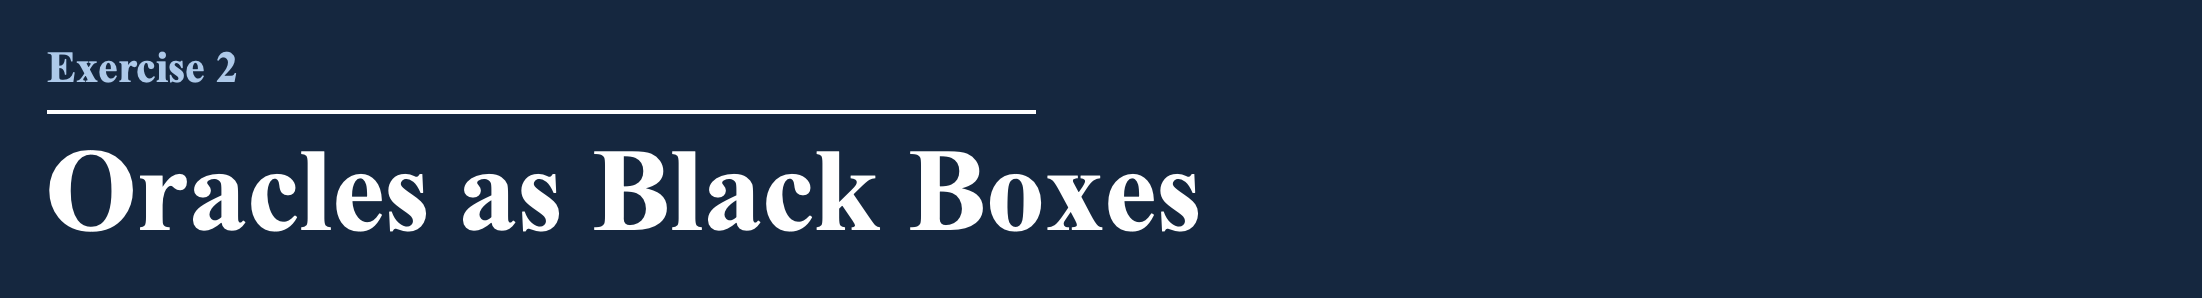

<div style="
  background-color: rgba(0, 170, 255, 0.1); 
  padding: 10px; 
  border-left: 3px solid #00aaff;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Task 2:</b> <br>

---

Build a quantum oracle that marks the correct answer in a search space by flipping its sign - without changing the others.

You’ll simulate a hardcoded oracle that flips the phase of one specific state (e.g. $\ket{11}$), and understand how this prepares it for amplification.


</div>

**Theory:**

In Grover’s algorithm, the oracle is a black box: it tells you whether your guess is correct, but without revealing what the answer is.

You (the observer) do not know the answer. The oracle is provided as part of the problem setup. Your job is to use quantum interference to find the answer, not be told it.

The oracle tags the correct state by flipping its phase, turning it from +1 to -1. This doesn’t change the probability yet, but prepares it for amplification by the next step (diffusion).

We're going to simulate the oracle here by manually flipping one of the states $ |11⟩ $.

After applying Hadamard gates to both qubits, we’re in a uniform superposition:

$$ ∣𝜓⟩ = ∣00⟩+∣01⟩+∣10⟩+∣11⟩ $$

The oracle for $ |11⟩ $ flips its phase:


$$ ∣𝜓⟩ = ∣00⟩+∣01⟩+∣10⟩−∣11⟩ $$
Only the sign of $ |11⟩ $ changes, nothing else.

<div style="
  background-color: rgba(255, 255, 0, 0.1); 
  padding: 10px; 
  border-left: 3px solid #ffd700;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Definition 5: The Controlled Z Gate</b> <br>

---

The Controlled-Z gate is a 2-qubit gate that applies a Z gate (i.e., flips the phase) to the target qubit only if the control qubit is 1.

**Matrix Form (4x4)**

The matrix representation of the CZ gate is:

\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}

This would flip only the $ \ket{11} state$

In Qiskit we can use a CZ by:
`qc.cz(control, target)`

(Since CZ is symmetric, the control and target can be interchanged)

</div>

**Exercise 2:**

Fix the apply_oracle() function apply an oracle to the circuit.

In [26]:
# =================================== #
# === Run this code as is first ===== #
# =================================== #

qc = equal_state(n_qubits)

def apply_oracle(qc):
    """
    Apply an oracle to the circuit.
    The oracle flips the sign of the |11> state.
    """
    # ============================================================= #
    # TODO - FIX the circuit to flip the sign of the |11> state
    # Maybe play around with the gate we just introduced 


    # ============================================================= #

    return qc

qc = apply_oracle(qc)

# Add measurement
qc.measure(range(n_qubits), range(n_qubits))
# Simulate the circuit using the QASM simulator
backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts() # Get the measurement counts


*This time when you run the report pay special attention to the visual of the quantum state, remeber you're aiming to flip the sign.*

In [27]:
# ====== View the state of the qubit  ====== #
qc.remove_final_measurements(inplace=True)
state = Statevector.from_instruction(qc)
display(state.draw('latex'))

In [28]:
# ====== Custom Report Layout - Do not edit  ====== #

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Histogram (left, spans both rows)
ax_hist = fig.add_subplot(gs[:, 0])
plot_histogram(counts, ax=ax_hist)
ax_hist.set_title("Measurement Histogram")

# Draw Circuit (top-right)
ax_circ = fig.add_subplot(gs[0, 1])
qc_with_meas = qc.copy()
qc_with_meas.measure_all()
qc_with_meas.draw(output='mpl', ax=ax_circ)
ax_circ.set_title("Quantum Circuit")

plt.tight_layout()
plt.show()
# ====== Custom Report Layout - Do not edit  ====== #

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

<details>
<summary>Solution - Try to google and play around before peeking at the solution</summary>

``` 
qc.cz(0, 1)
```

</details>

***Takeaway:***

*- The oracle is problem-defined, you don’t know the target in advance.*

*- It flips the phase of the correct answer (no measurement yet).*

*- This prepares it for the interference in the next step.*

**Food for thought:**

- Why can you see the sign change in the state and not in the histogram?
- Can you change the oracle to mark |01⟩ or |10⟩? (Hint: use X gates before/after)

---

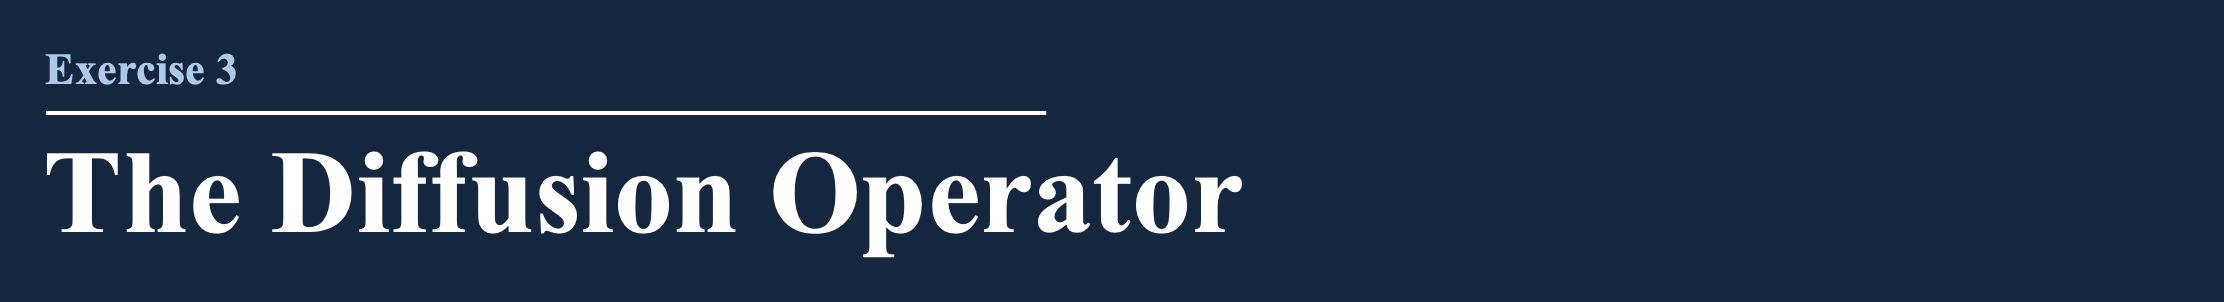


<div style="
  background-color: rgba(0, 170, 255, 0.1); 
  padding: 10px; 
  border-left: 3px solid #00aaff;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Task:</b> <br>

Understand and build the Grover Diffusion Operator, which amplifies the marked state using a clever reflection trick.

</div>

After the oracle has tagged the correct answer how do we get observe it? Through quantum gates the diffusion operator amplifies its probability by flipping all the amplitudes around their average.

The operator performs this transformation:

$∣ψ⟩→2∣avg⟩−∣ψ⟩$

It flips amplitudes around the mean — amplifying the marked state (which had a negative amplitude).

**Theory: The Diffusion Step (Dice Analogy Continued)**

You’ve built a magical die that floats in superposition - it’s "ready to land on any face." One face was secretly tagged by the oracle with invisible glue, but you still don't know which and all sides are still equally likely if you roll it.  This is where the diffusion operator comes in. It acts like a special quantum paintbrush that magnifies the sticky side while dimming the others - making it more likely that you roll the correct face when you measure.

What’s Actually Happening? The diffusion operator does one elegant thing:

It reflects the amplitudes of all quantum states around their average. So if one amplitude is below the average (because it was phase-flipped by the oracle before!), this reflection makes it stick out above the rest - like turning a dip into a peak.

**Mathematical Explanation:**

Suppose we have 4 sides (2 qubits) and therefore 4 basis states: $\ket{00}$, $\ket{01}$, $\ket{10}$, and $\ket{11}$.

After the oracle flips the phase of $\ket{11}$, the amplitudes look like:

<div align="center">

<table style="border-collapse: collapse; font-size: 16px;">
  <thead>
    <tr style="background-color:rgb(54, 71, 83); color: white;">
      <th style="padding: 8px 12px;">Face (State)</th>
      <th style="padding: 8px 12px;">Amplitude</th>
      <th style="padding: 8px 12px;">Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 6px 12px;">|00⟩</td>
      <td style="padding: 6px 12px;">+0.5</td>
      <td style="padding: 6px 12px;">25%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|01⟩</td>
      <td style="padding: 6px 12px;">+0.5</td>
      <td style="padding: 6px 12px;">25%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|10⟩</td>
      <td style="padding: 6px 12px;">+0.5</td>
      <td style="padding: 6px 12px;">25%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|11⟩</td>
      <td style="padding: 6px 12px;">−0.5</td>
      <td style="padding: 6px 12px;">25%</td>
    </tr>
  </tbody>
</table>

</div>

So now we do the quantum reflection (diffusion), which acts by "Flipping each weight over the average"

What is the average?
$$ Average = \frac{0.5 + 0.5 + 0.5 + (-0.5)}{4} = 0.25$$

Flip about the average:
For each amplitude, do:
$$ newvalue = 2 * average - currentvalue $$

Examples:

For $\ket{00} = 2 \times 0.25 - 0.5 = 0 $

For $\ket{11} = 2 \times 0.25 - (-0.5) = 0 $

Now after:

<div align="center">

<table style="border-collapse: collapse; font-size: 16px;">
  <thead>
    <tr style="background-color: rgb(54, 71, 83); color: white;"> 
      <th style="padding: 8px 12px;">Face (State)</th>
      <th style="padding: 8px 12px;">Amplitude</th>
      <th style="padding: 8px 12px;">Probability</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 6px 12px;">|00⟩</td>
      <td style="padding: 6px 12px;">0.0</td>
      <td style="padding: 6px 12px;">0%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|01⟩</td>
      <td style="padding: 6px 12px;">0.0</td>
      <td style="padding: 6px 12px;">0%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|10⟩</td>
      <td style="padding: 6px 12px;">0.0</td>
      <td style="padding: 6px 12px;">0%</td>
    </tr>
    <tr>
      <td style="padding: 6px 12px;">|11⟩</td>
      <td style="padding: 6px 12px;">1.0</td>
      <td style="padding: 6px 12px;">100%</td>
    </tr>
  </tbody>
</table>

</div>

When we now measure the state it is guarenteed to show $\ket{11}$, or is guarenteed to land on the answer to out puzzle when we roll the dice

Whats happened is the diffusion operator has found the average amplitude, reflected each amplitude about it, causing constructive interference (for the marked item) and destructive interference for the rest. And what is so powerful is that it takes only 1 repition here instead of the classical 2 it would take to find the solution.

How do we build this with gates?  Below is the circuit for when there are two qubits like we've doing so far:

<div align="center">

<pre>
     ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘
c: 2/══════════════════
</pre>

</div>

Complete the circuit below to find the value and complete your first basic implementation fo Grover's algorithm.

**Exercise 3:**

Build the diffusion_operator() for a 2 qubit circuit.

In [29]:
# =================================== #
# === Run this code as is first ===== #
# =================================== #

n_qubits = 2 # Dont change this as we'll be exploring what happens with more qubits later

qc = equal_state(n_qubits)
qc = apply_oracle(qc)

def diffusion_operator(qc, n_qubits):
    """
    Apply the Grover diffusion operator for 2 qubits
    """
    # ============================================================= #
    # TODO - Implement the circuit above and observe the results
    # The first part has been done for you

    qc.h(range(n_qubits))

    # ============================================================= #

diffusion_operator(qc, n_qubits)

# Add measurement
qc.measure(range(n_qubits), range(n_qubits))
# Simulate the circuit using the QASM simulator
backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
counts = result.get_counts() # Get the measurement counts

In [30]:
# ====== View the state of the qubit  ====== #
qc.remove_final_measurements(inplace=True)
state = Statevector.from_instruction(qc)
display(state.draw('latex'))

In [31]:
# ====== Custom Report Layout - Do not edit  ====== #
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Left: Histogram spans full height of column 0
ax_hist = fig.add_subplot(gs[0, 0])
plot_histogram(counts, ax=ax_hist)
ax_hist.set_title("Measurement Histogram")

# Right: Circuit spans full height of column 1
ax_circ = fig.add_subplot(gs[0, 1])
qc_with_meas = qc.copy()
qc_with_meas.measure_all()
qc_with_meas.draw(output='mpl', ax=ax_circ)
ax_circ.set_title("Quantum Circuit")

plt.tight_layout()
plt.show()
# ====== Custom Report Layout - Do not edit  ====== #

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

<details>
<summary> Solution - Try to google and play around before peeking at the solution</summary>

``` 
    qc.h(range(n_qubits))

    qc.z(range(n_qubits))

    qc.cz(0, 1)

    qc.h(range(n_qubits))
```

</details>

</div>

***Takeaway:***

*The diffusion operator is like a quantum signal booster. After the oracle flips the target’s phase, diffusion makes it stand out by increasing its amplitude - making it more likely to be measured.*

---

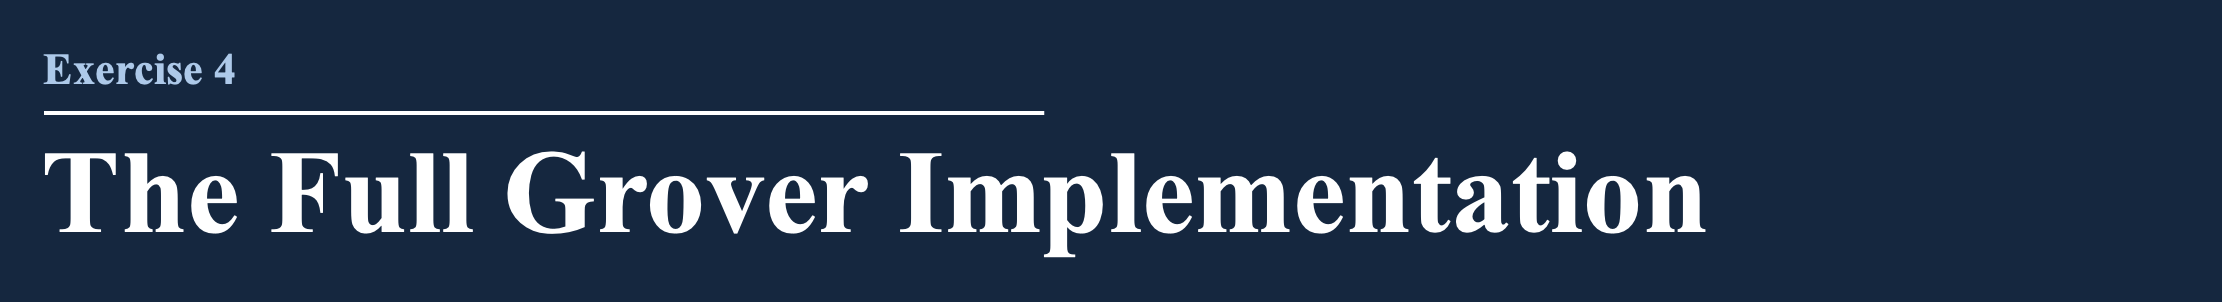

<div style="
  background-color: rgba(0, 170, 255, 0.1); 
  padding: 10px; 
  border-left: 3px solid #00aaff;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Task:</b> <br>

Design and implement a scalable version of Grover's algorithm that can search for one or more marked states in a large quantum database.

</div>

**Theory:**

So far, you've implemented Grover's algorithm for 2 qubits (4 items, $ N = 4 $ and a single marked solution ($ M = 1 $).

Now, let's generalize:

General Search Problem:
- $N = 2^n$: total number of items (from $n$ qubits)
- $M$: number of marked solutions (states that satisfy a condition)
- The goal: amplify the amplitudes of all $M$ marked states

Number of Grover Iterations
The optimal number of iterations is:
$$ r \approx \frac{\pi}{4} \sqrt{\frac{N}{M}}$$

This ensures that you rotate the superposition state as close as possible to the subspace of solutions.

**Oracle (Generalised):**

You can use the same kind of construction as before, apply X gates to qubits corresponding to 0s in the marked state, and a multi-controlled-Z (via mcx), then undo the X gates. Qiskit does not provide a "GroverOracle" function out of the box, but you can define your own.

Example - Oracle for marking a single qubit:
<div align="center">

<pre>
     ┌───┐           ┌───┐
q_0: ┤ H ├───────────┤ H ├
     ├───┤           ├───┤
q_1: ┤ H ├───────────┤ H ├
     ├───┤           ├───┤
q_2: ┤ H ├───────────┤ H ├
     ├───┤           ├───┤
q_3: ┤ H ├───────────┤ H ├
     ├───┤     ┌───┐ ├───┤
q_4: ┤ H ├──■──┤ Z ├─┤ H ├
     └───┘  │  └───┘ └───┘
anc: ───────■────────────────
</pre>

</div>

Example - Oracle for marking where q_1 = 1 and q_4 = 1:
In this case the oracle should flip the phase of all basis states where both q_1 and q_4 = 1. To implement this, we can use a controlled-controlled-Z (CCZ) gate. The z gate is controlled by q_1 and q_4.
<div align="center">

<pre>
     ┌───┐                 ┌───┐
q_0: ┤ H ├─────────────────┤ H ├
     ├───┤                 ├───┤
q_1: ┤ H ├──■──────────────┤ H ├
     ├───┤  │              ├───┤
q_2: ┤ H ├──┼──────────────┤ H ├
     ├───┤  │              ├───┤
q_3: ┤ H ├──┼──────────────┤ H ├
     ├───┤  │     ┌───┐    ├───┤
q_4: ┤ H ├──■─────┤ Z ├────┤ H ├
     └───┘        └───┘    └───┘

</pre>

</div>

**Diffusion Operator (Generalised):**

The diffusion operator for any n qubits is:

- Hadamard on all qubits
- X on all qubits
- Apply Z gate on ∣00…0⟩ via multi-controlled-Z
- X on all qubits
- Hadamard on all qubits

Example - Diffusion Operator for 5 Qubits:
<div align="center">

<pre>
     ┌───┐┌───┐   ┌───┐   ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─■─┤ X ├─■─┤ H ├┤ H ├
     ├───┤├───┤ │ ├───┤ │ ├───┤├───┤
q_1: ┤ H ├┤ X ├─■─┤ X ├─■─┤ H ├┤ H ├
     ├───┤├───┤ │ ├───┤ │ ├───┤├───┤
q_2: ┤ H ├┤ X ├─■─┤ X ├─■─┤ H ├┤ H ├
     ├───┤├───┤ │ ├───┤ │ ├───┤├───┤
q_3: ┤ H ├┤ X ├─■─┤ X ├─■─┤ H ├┤ H ├
     ├───┤├───┤ │ ├───┤ │ ├───┤├───┤
q_4: ┤ H ├┤ X ├─■─┤ X ├─■─┤ H ├┤ H ├
     └───┘└───┘   └───┘   └───┘└───┘
</pre>

</div>

**Exercise 4**

This is the final step, fixing and implementing Grover's algorithm. See how far you can get on your own!

In [32]:
def apply_oracle(circuit, marked_state): # Part 1
    """
    Flips the sign of the amplitude for the marked basis state.
    marked_state: binary string (e.g. '101')
    """
    n = len(marked_state) # number of qubits

    # ============================================================= #
    # TODO - Implement the oracle generalised circuit
    # The first part has been done for you

    # Apply X to match |00...0⟩ if needed
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            circuit.x(i)

    # Multi-controlled-Z = H + MCX + H


    # Uncompute X


    # ============================================================= #

def diffusion_operator(circuit, n_qubits): # Part 2
    """
    Implements the diffusion operator for n qubits.
    """
    # ============================================================= #
    # TODO - Implement the generalised diffusion operator circuit
    # The first part has been done for you, 

    circuit.h(range(n_qubits))
    circuit.x(range(n_qubits))
    circuit.h(n_qubits - 1)

    # ============================================================= #

def grover_search(n_qubits, marked_state, num_iterations=None): # Part 3
    N = 2 ** n_qubits
    M = 1  # number of solutions
    if num_iterations is None:
        num_iterations = int((pi / 4) * (N / M) ** 0.5)

    qc = QuantumCircuit(n_qubits, n_qubits)

    # ============================================================= #
    # TODO - Implement the Grover search circuit
    # The first part has been done for you

    # Step 1: Superposition
    qc.h(range(n_qubits))

    # Step 2: Grover iterations


    # ============================================================= #

    # Step 3: Measurement
    qc.measure(range(n_qubits), range(n_qubits))
    return qc

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

<details>
<summary> Solution - Part 1 - apply_oracle</summary>

``` 
# Multi-controlled-Z = H + MCX + H
    circuit.h(n-1)
    circuit.mcx(list(range(n-1)), n-1)
    circuit.h(n-1)

# Uncompute X
    for i, bit in enumerate(reversed(marked_state)):
        if bit == '0':
            circuit.x(i)
```

</details>
<br></br>
<details>
<summary> Solution - Part 2 - diffusion_operator</summary>

Already done for you:
```
circuit.h(range(n_qubits))
circuit.x(range(n_qubits))
circuit.h(n_qubits - 1)
```
The solution:
```
circuit.mcx(list(range(n_qubits - 1)), n_qubits - 1)
circuit.h(n_qubits - 1)
circuit.x(range(n_qubits))
circuit.h(range(n_qubits))
```

</details>
<br></br>
<details>
<summary> Solution - Part 3 - grover_search</summary>

```
for i in range(num_iterations):
    apply_oracle(qc, marked_state)
    diffusion_operator(qc, n_qubits)
```

</details>

</div>

In [33]:
# ====== Run Grover ====== #
n_qubits = 3 # Number of qubits
marked = '101' # Marked state
qc = grover_search(n_qubits, marked)

backend = Aer.get_backend('qasm_simulator')
result = backend.run(qc, shots=1024).result() # Change the shots to see what happens
counts = result.get_counts()

**Locally Test Script**
The test script very basically verifies that your Grover's algorithm implementation is logically correct before you submit it to real IBM Quantum backend. 
- Checks whether the final measured result is the correct marked state.

Will need to change the parameters in the test file if they are changed in your implementation

In [34]:
# Dynamically load the test file
with open("grovers_test.py") as f:
    code = f.read()
exec(code)

# Now run the test function from the loaded script
test_full_grover_run()


In [35]:
# ====== View the state of the qubit  ====== #
qc.remove_final_measurements(inplace=True)
state = Statevector.from_instruction(qc)
display(state.draw('latex'))

In [36]:
# ====== Custom Report Layout - Do not edit  ====== #
# Create vertical layout (2 rows, 1 column)
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])

# Top: Circuit
ax_circ = fig.add_subplot(gs[0, 0])
qc_with_meas = qc.copy()
qc_with_meas.measure_all()
qc_with_meas.draw(output='mpl', ax=ax_circ)
ax_circ.set_title("Quantum Circuit")

# Bottom: Histogram
ax_hist = fig.add_subplot(gs[1, 0])
plot_histogram(counts, ax=ax_hist)
ax_hist.set_title("Measurement Histogram")

plt.tight_layout()
plt.show()
# ===== Custom Report Layout - Do not edit  ====== #

<div style="
  background-color: rgba(255, 0, 187, 0.1); 
  padding: 10px; 
  border-left: 3px solid rgb(255, 0, 162);
  border-radius: 6px;
  font-family: sans-serif;
">

**Extension - Further Exploration:**

Play around with the "Run Grover" scripts parameters and see what you can do!

*Note you might need to change number of solutions as well*

</div>

## Congratulations!

You’ve built Grover’s Algorithm from the ground up:
- You saw how quantum superposition effects state
- You used an oracle to secretly mark the answer
- You amplified the correct answer with the diffusion operator

---

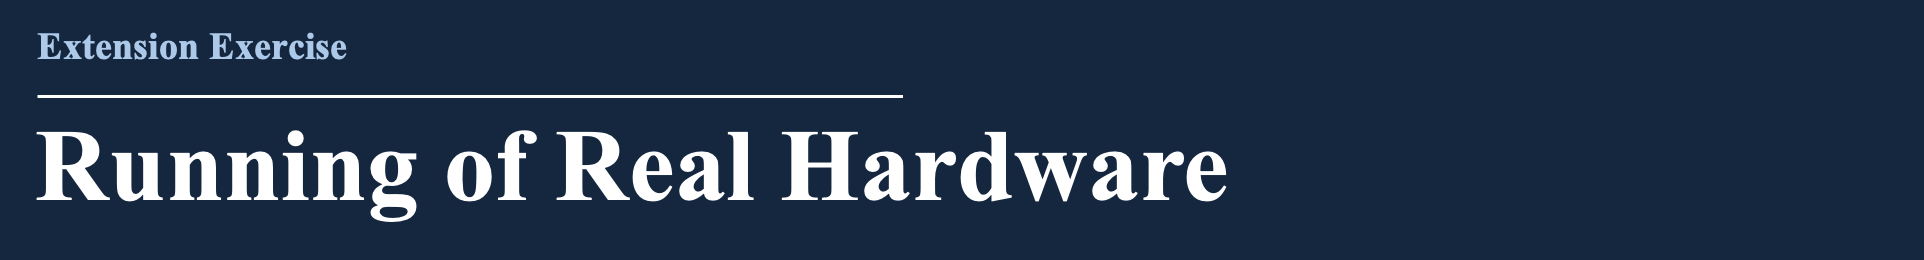

<div style="
  background-color: rgba(0, 170, 255, 0.1); 
  padding: 10px; 
  border-left: 3px solid #00aaff;
  border-radius: 6px;
  font-family: sans-serif;
">
  <b>Extension Task:</b> <br>

Try running Grover's algorithm on read quantum hardware, tinker below and get it running.

</div>

**How to Estimate Hardware Runtime**

Configuration:
- Number of qubits: 3
- Marked state: '101'
- Grover iteration: 1
- Number of shots: 1024
- Backend used: ibmq_belem

Circuit depth = lets say its 25 for this example

IBM Quantum Hardware processes circuits rougly at 10 micro seconds per circuit shot short-depth circuits like this one.
So for 1024 shots: $runtime = 1024 \times 10 \mu s = 10.24ms$
Accounting for latency etc and exluding queue time: $20-100ms$

The Full Code to Run Grover's algorithm on Real Hardware is below, you just need to load in your IBM account.

In [ ]:
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor

IBMQ.save_account('account_token') # Replace with your own token

Notes:
- optimization_level=3 tries to reduce errors and gate depth
- job_monitor() gives you real-time status
- Real devices have a queue, it may take a few minutes to run

In [ ]:
# Load your IBM Quantum account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')  # or your specific hub

# Choose a real backend (example: 5-qubit device)
backend = provider.get_backend('ibmq_belem')  # Or 'ibmq_quito', 'ibmq_lima', etc.

# Prepare your Grover circuit
n_qubits = 3
marked = '101'
qc = grover_search(n_qubits, marked)

# Transpile for the backend
qc_transpiled = transpile(qc, backend=backend, optimization_level=3)

# Execute the circuit on real quantum hardware
job = backend.run(qc_transpiled, shots=1024)
job_monitor(job)

# Get and display the results
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

Re-run / Retrieve Results Later
If you saved the job ID, you can later retrieve the job like this:

In [ ]:
retrieved_job = backend.retrieve_job('your_saved_job_id')
result = retrieved_job.result()
counts = result.get_counts()
plot_histogram(counts, title="Retrieved Job Results")

----